In [1]:
import numpy as np
from matplotlib import pyplot as plt
import os

In [2]:
from matplotlib import rc
rc('font',**{'family':'serif','serif':['Times']})
rc('text', usetex=True)

In [3]:
# beta = 0.587033
# gamma = 3.09554
beta = np.pi/2
gamma = np.pi/2
theta = 3 * np.pi/8
phi = np.pi/2

In [4]:
D = 1001
p = np.arange(0,D,1)
sqrt2 = np.sqrt(2)
w = 2*np.pi/D
im = complex(0.0,1.0)
U = np.zeros((D,2,2),np.complex128)
# U[:,0,0] = -1/sqrt2 * (np.cos(w*p) - im*np.sin(w*p)) # [0] representa |0> y [1] |1>
# U[:,1,0] = 1/sqrt2 * (np.cos(w*p) + im*np.sin(w*p))
# U[:,0,1] = 1/sqrt2 * (np.cos(w*p) - im*np.sin(w*p))
# U[:,1,1] = 1/sqrt2 * (np.cos(w*p) + im*np.sin(w*p))
U[:,0,0] = np.exp(im*gamma) * np.cos(beta/2) * np.exp(-im*p)
U[:,1,0] = -np.exp(im*gamma) * np.sin(beta/2) * np.exp(im*p)
U[:,0,1] = np.sin(beta/2) * np.exp(-im*p)
U[:,1,1] = np.cos(beta/2) * np.exp(im*p)
U1 = np.zeros((D,2,2),np.complex128)
U2 = np.zeros((D,2,2),np.complex128)

In [5]:
# For convinience, operate in p basis
instate = np.zeros((D,2,2),np.complex128)
# instate[0,0,0] = 0.5
# instate[0,1,0] = 0.5*im
# instate[0,0,1] = 0.5*im
# instate[0,1,1] = - 0.5
instate[0,0,0] = np.cos(theta) * np.cos(theta)
instate[0,1,0] = np.cos(theta) * np.sin(theta) * np.exp(im*phi)
instate[0,0,1] = np.cos(theta) * np.sin(theta) * np.exp(im*phi)
instate[0,1,1] = np.sin(theta) * np.sin(theta) * np.exp(2*im*phi)
pstate = np.zeros((D,2,2),np.complex128)
finstate = np.zeros((D,2,2),np.complex128)
transf = np.zeros((D,D),np.complex128)
omegap = np.exp(im*w*p)
for m in p:
    transf[m,:] = omegap**m
    U1[m,:,:] = np.identity(2)
    U2[m,:,:] = np.identity(2)
np.multiply(1/np.sqrt(D),transf,out=transf);
np.einsum('pq,qmn -> pmn',transf,instate,out=pstate);

In [6]:
interaction_pattern = "r"
# qubitstate_size = 2**n_qubits
# T = seed.size
cwd = os.getcwd()
n_qubits = 2
qubitstate_size = 2**n_qubits
# filename = "batch_instates/ordered_seed.txt"
# filename = "batch_instates/random_seed.txt"
# filename = interaction_pattern+"seed_dim" + str(D) + "_q" + str(n_qubits) + ".txt"
filename = interaction_pattern+"seed_dim101_q" + str(n_qubits) + ".txt"
seed = np.genfromtxt(cwd+"/data/seeds/"+filename, usecols = 0, delimiter=",", dtype = int)
# seed = np.genfromtxt("C:/dev/Multicqw/data/seeds/"+interaction_pattern+filename, usecols = 0, delimiter=",", dtype = int)
T = seed.size

In [7]:
concurrences = np.zeros(T,float)
j = 0
for int_qubit in seed:
    if int_qubit:
        np.einsum('pjk,pkl->pjl',U2,U,out=U2)
    else:
        np.einsum('pjk,pkl->pjl',U1,U,out=U1)

    evop = np.einsum('pjk,pmn->pjkmn',U1,U2)
    np.einsum('pjkmn,pkn->pjm',evop,pstate,out=finstate)
    result = np.einsum('pq,pmn->qmn',np.conj(transf),finstate)
    concurrences[j] = np.sum(2*np.absolute(np.multiply(result[:,0,0],result[:,1,1]) - np.multiply(result[:,0,1],result[:,1,0])))
    j += 1

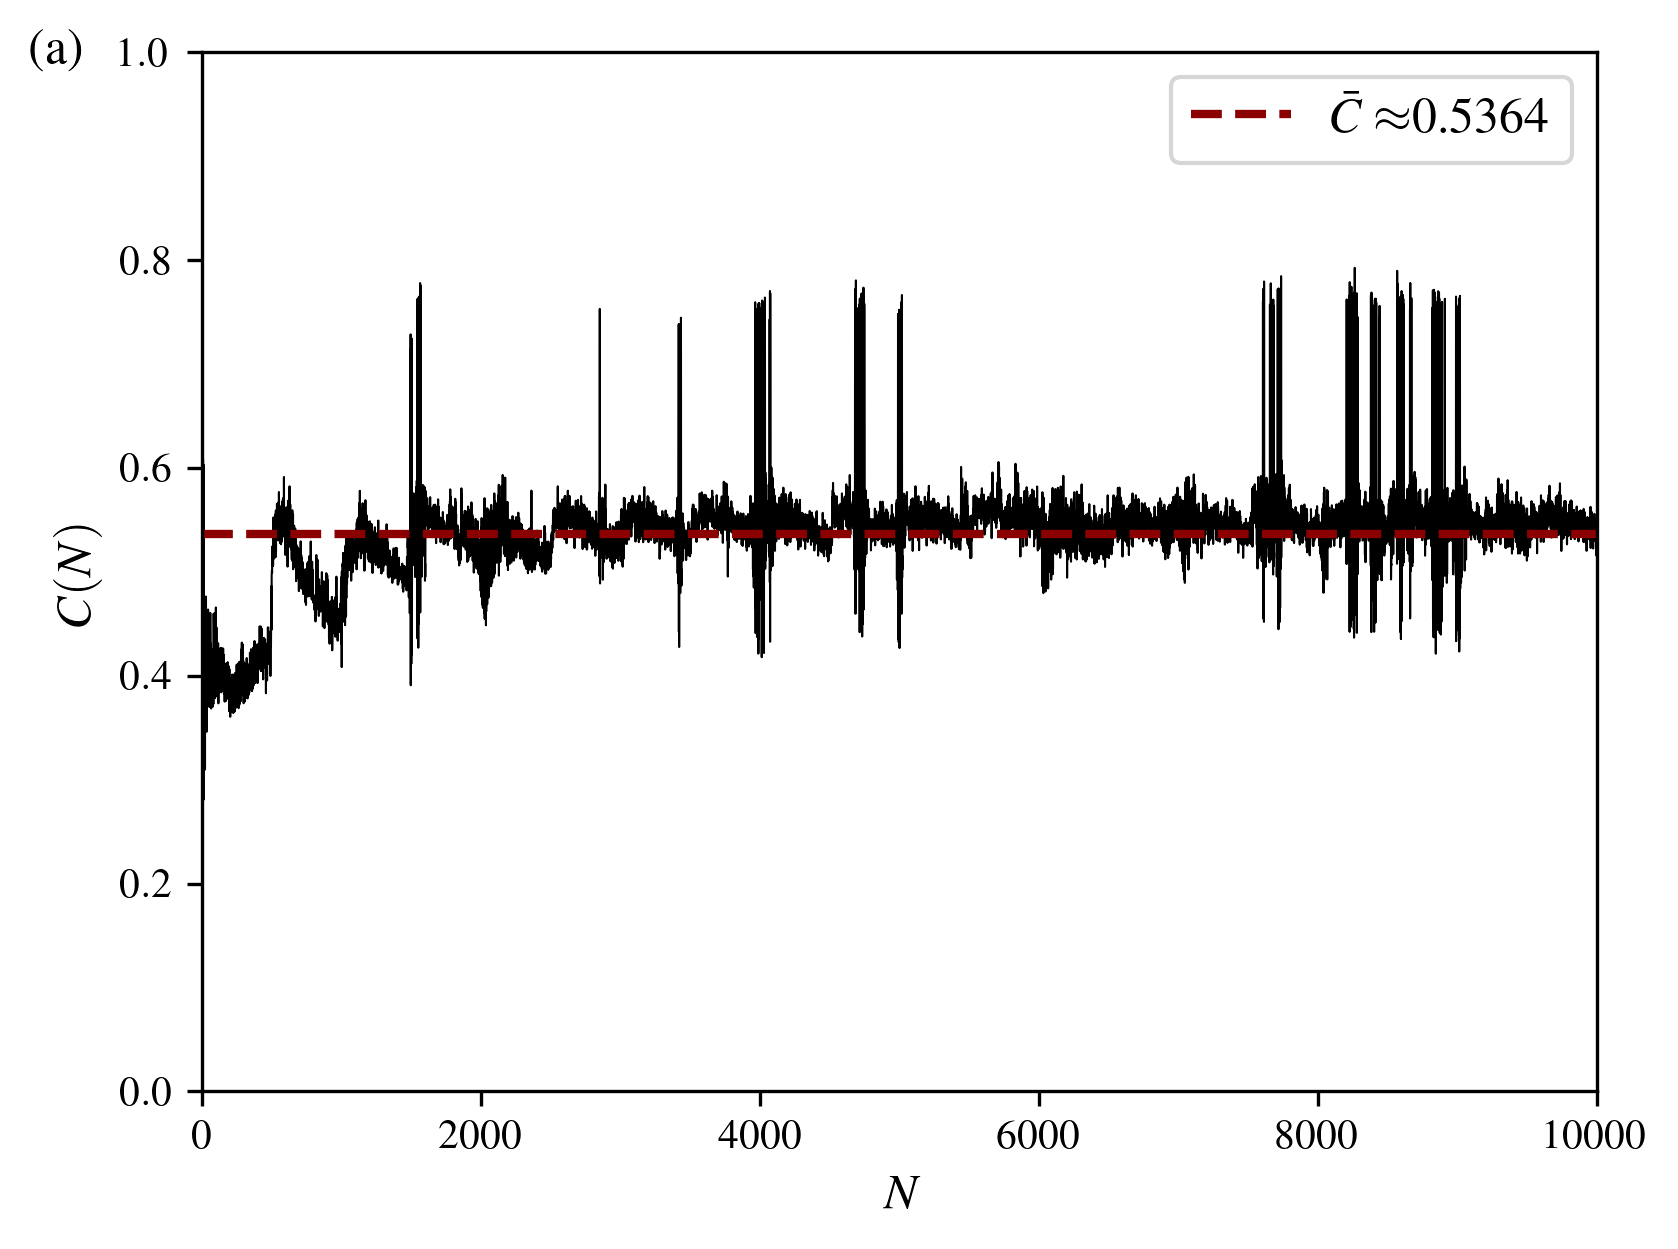

In [8]:
t = np.arange(0,T)
avg = np.average(concurrences)
fig = plt.figure(figsize=(6,4.5),dpi=300)
fig.clear()
ax = fig.subplots()
fig.text(0.045,0.88, '(a)', horizontalalignment='center', verticalalignment='center', fontsize=12)
ax.plot(t,concurrences,'k-', lw=0.5)
ax.set_xlim(0,T)
ax.set_xlabel(r'$N$',fontsize=12)
ax.set_ylim(0,1)
ax.set_ylabel(r'$C(N)$',fontsize=12)
ax.plot((0,T),(avg,avg),'--', label = r'$\bar{C} \approx $' + str(avg)[:6],lw=2,color="darkred")
ax.legend(loc='upper right',fontsize=12)